# Metrics probabilistic forecasting

In point estimate forecasting, the model outputs a single value that ideally represents the most likely value of the time series at future steps. In this scenario, the quality of the predictions can be assessed by comparing the predicted value with the true value of the series. Examples of metrics used for this purpose are the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).

In probabilistic forecasting, however, the model does not produce a single value, but rather a representation of the entire distribution of possible predicted values. In practice, this is often represented by a sample of the underlying distribution (e.g. 50 possible predicted values) or by specific quantiles that capture most of the information in the distribution.

This notebook explore some metrics that can be used to assess the quality of probabilistic forecasts: coverage, interval width, interval area and continuous ranked probability score (CRPS).

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Fore a more detailed explanation of  CRPS, please refer to [Continuous Ranked Probability Score (CRPS) in probabilistic forecasting](./probabilistic-forecasting-crps-score.ipynb).

</div>

## Libraries and data

In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)

# Modelling and Forecasting
# ==============================================================================
import skforecast
import sklearn
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [6]:
# Load data
# ==============================================================================
data = fetch_dataset('ett_m2', raw=True)
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.asfreq('15min')
data = data.resample(rule="1h", closed="left", label="right").mean()
data.head(3)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years × 365 days × 24 hours × 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 8)


,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.55100,4.12575,1.26050,37.83825
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.13700,3.59025,0.62900,36.84925
2016-07-01 03:00:00,38.240000,11.41350,35.343501,9.10725,3.06000,0.31175,35.91575


In [7]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-10-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2017-10-01 23:00:00  (n=10991)
Dates validacion : 2017-10-02 00:00:00 --- 2018-04-03 23:00:00  (n=4416)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 20:00:00  (n=2013)


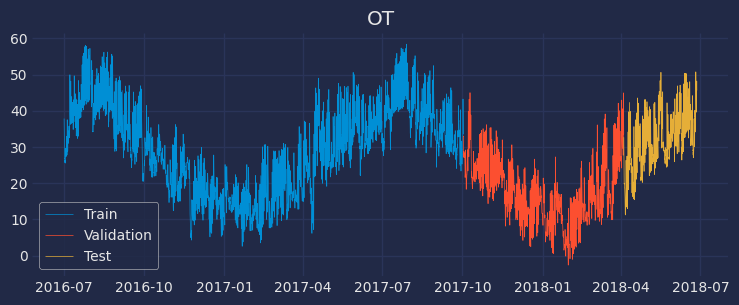

In [9]:
# Plot partitions of the target series
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

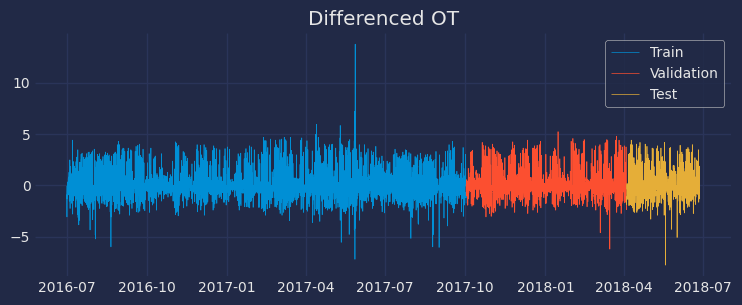

In [10]:
# Plot partitions after differencing
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'].diff(1), label='Train')
ax.plot(data_val['OT'].diff(1), label='Validation')
ax.plot(data_test['OT'].diff(1), label='Test')
ax.set_title('Differenced OT')
ax.legend();

## Probabilistic forecasting

In [13]:
# Create forecaster
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=24)
lags = [1, 2, 3, 4, 5, 6, 9, 12, 15, 17, 20, 23, 24, 42]
forecaster = ForecasterRecursive(
                 regressor       = Ridge(random_state=15926, alpha=1.1075),
                 lags            = lags,
                 differentiation = 1,
                 window_features = window_features,
                 binner_kwargs   = {'n_bins': 10}
             )

  0%|          | 0/184 [00:00<?, ?it/s]

,mean_absolute_error
0,2.337103


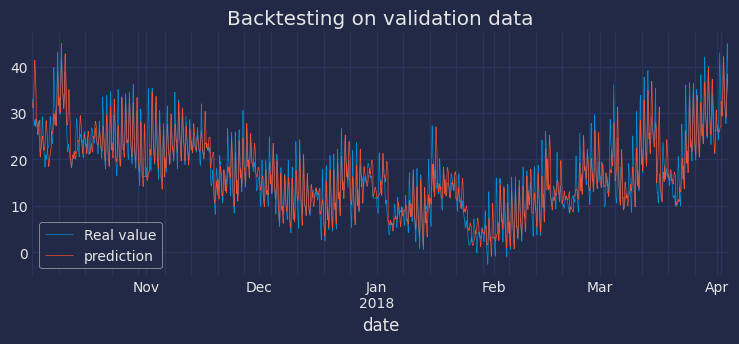

In [14]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_train, :]),
        steps              = 24,  # all hours of next day
        differentiation    = 1,
     )

metric_val, predictions_val = backtesting_forecaster(
                                forecaster    = forecaster,
                                y             = data.loc[:end_validation, 'OT'],
                                #exog          = data.loc[:end_validation, selected_exog],
                                cv            = cv,
                                metric        = 'mean_absolute_error',
                                n_jobs        = 'auto',
                                verbose       = False,
                                show_progress = True
                              )
display(metric_val)
fig, ax = plt.subplots(figsize=(8, 3))
data.loc[end_train:end_validation, 'OT'].plot(ax=ax, label='Real value')
predictions_val['pred'].plot(ax=ax, label='prediction')
ax.set_title("Backtesting on validation data")
ax.legend();

positive    2213
negative    2203
Name: count, dtype: int64


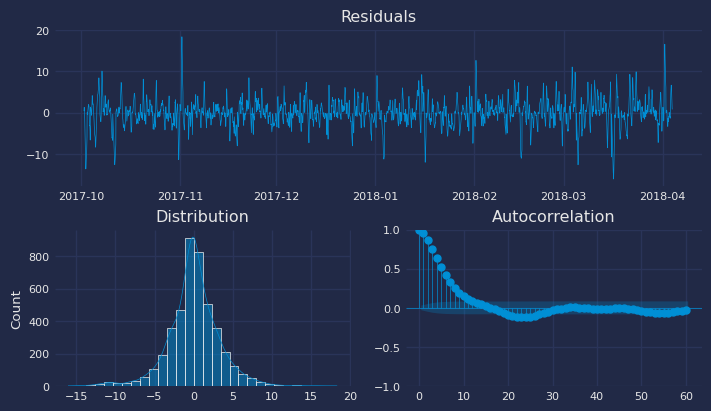

In [15]:
# Out-sample residuals distribution
# ==============================================================================
residuals = data.loc[predictions_val.index, 'OT'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [16]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_train, 'OT']), #exog=data.loc[:end_train, selected_exog])
forecaster.set_out_sample_residuals(
    y_true = data.loc[predictions_val.index, 'OT'], 
    y_pred = predictions_val['pred']
)

In [17]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
        initial_train_size = len(data.loc[:end_validation, :]),
        steps              = 24,  # all hours of next day
        differentiation    = 1
     )

metric, predictions = backtesting_forecaster(
                          forecaster              = forecaster,
                          y                       = data['OT'],
                          #exog                    = data[selected_exog],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                     )
predictions

  0%|          | 0/84 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2018-04-04 00:00:00,32.638045,32.087258,33.463127
2018-04-04 01:00:00,32.004370,30.979583,33.178849
2018-04-04 02:00:00,31.382605,29.609948,33.166212
2018-04-04 03:00:00,30.796440,28.226011,32.915206
2018-04-04 04:00:00,30.258138,27.369267,32.786187
...,...,...,...
2018-06-26 16:00:00,50.944630,39.627786,58.521350
2018-06-26 17:00:00,50.294509,38.819528,58.441486
2018-06-26 18:00:00,49.330692,38.369693,57.895196
2018-06-26 19:00:00,48.142845,37.760474,56.941477


Predicted interval coverage: 86.69 %
Area of the interval: 23226.98


,mean_absolute_error
0,2.957337


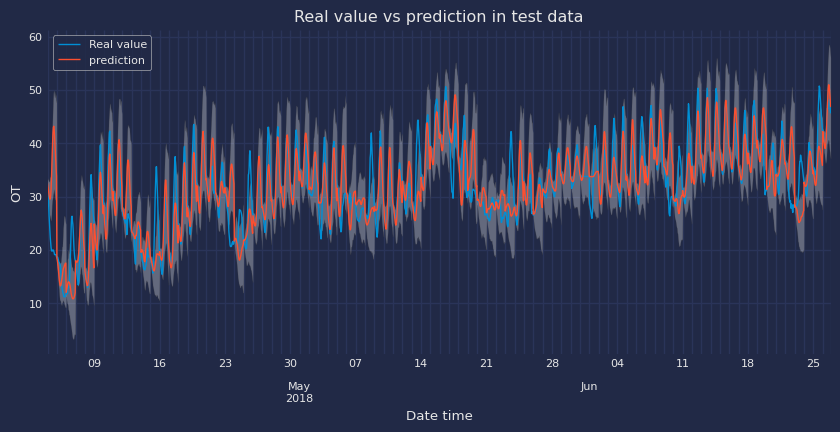

In [18]:
# Plot intervals
# ==============================================================================
plt.rcParams['lines.linewidth'] = 1
fig, ax = plt.subplots(figsize=(9, 4))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "OT",
    initial_x_zoom  = None,
    title           = "Real value vs prediction in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "OT",
    ax              = ax
)
fill_between_obj = ax.collections[0]
fill_between_obj.set_facecolor('white')
fill_between_obj.set_alpha(0.3)

# Predicted interval coverage (on test data)
# ==============================================================================
def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
        
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

coverage = empirical_coverage(
    y = data.loc[end_validation:, 'OT'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

display(metric)

## Estimation of multiple intervals

Prediction intervals are estimated for various nominal coverage levels—10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%, and 95%—and their actual coverage is assessed.

In [19]:
# Prediction intervals for different nominal coverages
# ==============================================================================
nominal_coverages = [[2.5, 97.5], [5, 95], [10, 90], [15, 85], [20, 80], [30, 70], [35, 65], [40, 60], [45, 55]]
observed_coverages = []
observed_areas = []

for coverage in nominal_coverages:
    metric, predictions = backtesting_forecaster(
                            forecaster              = forecaster,
                            y                       = data['OT'],
                            #exog                    = data[selected_exog],
                            cv                      = cv,
                            metric                  = 'mean_absolute_error',
                            interval                = coverage, # Nominal coverage
                            n_boot                  = 150,
                            use_in_sample_residuals = False,  # Use out-sample residuals
                            use_binned_residuals    = True,
                            n_jobs                  = 'auto',
                            verbose                 = False,
                            show_progress           = True
                         )
    observed_coverage = empirical_coverage(
        y = data.loc[end_validation:, 'OT'],
        lower_bound = predictions["lower_bound"], 
        upper_bound = predictions["upper_bound"]
    )
    observed_area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
    observed_coverages.append(100 * observed_coverage)
    observed_areas.append(observed_area)

results = pd.DataFrame({
            'Interval': nominal_coverages,
            'Nominal coverage': [coverage[1] - coverage[0] for coverage in nominal_coverages],
            'Observed coverage': observed_coverages,
            'Area': observed_areas
         })
results.round(1)


  0%|          | 0/84 [00:00<?, ?it/s]

KeyboardInterrupt: 